4423680/4422102 [==============================] - 0s 0us/step
train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8


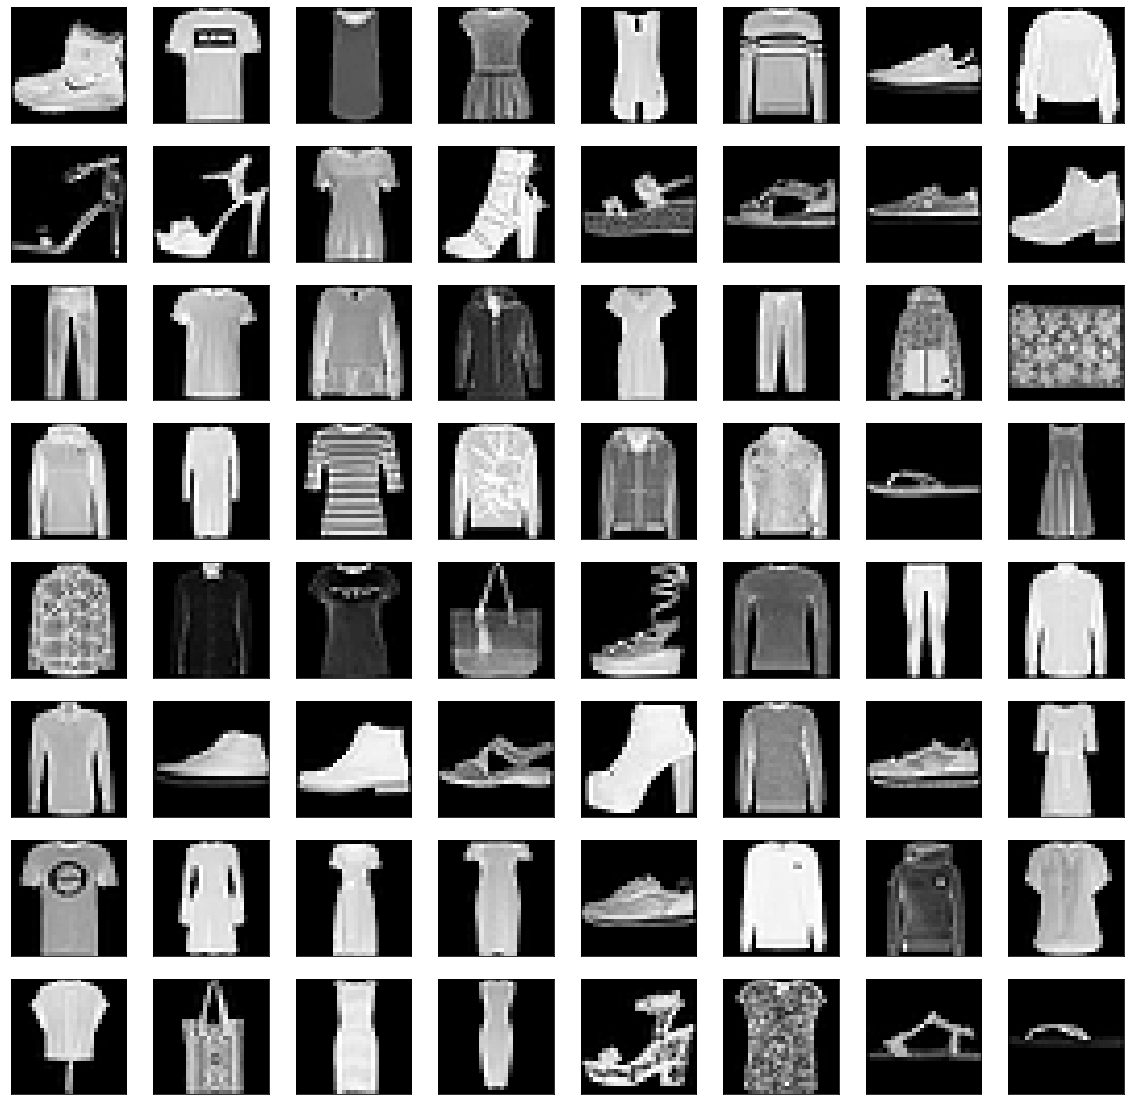

In [1]:
from tensorflow.keras import datasets, layers, models, utils, optimizers
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

(train_images, _), (_, _) = datasets.fashion_mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )

plt.figure( figsize=(20,20))

for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( train_images[i], cmap='gray' )

In [2]:
_, H, W = train_images.shape
train_x = (train_images.reshape(-1, H, W, 1) / 127.5 - 1).astype('float32')

print('train_x', type(train_x), train_x.shape, train_x.dtype)

train_x <class 'numpy.ndarray'> (60000, 28, 28, 1) float32


In [0]:
input_dim = 10

def gen_noise(batch_size):
    return np.random.uniform(-1, 1, (batch_size, input_dim))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0

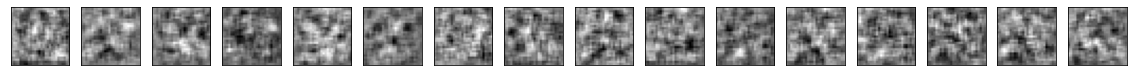

In [4]:
G = models.Sequential()

G.add(layers.Dense(7*7*128, input_dim=input_dim))
G.add(layers.LeakyReLU(0.2))
G.add(layers.Reshape((7, 7, 128)))
G.add(layers.UpSampling2D(size=(2, 2)))
G.add(layers.Conv2D(64, kernel_size=(5, 5), padding='same'))
G.add(layers.LeakyReLU(0.2))
G.add(layers.UpSampling2D(size=(2, 2)))
G.add(layers.Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

G.summary()

generated = G.predict(gen_noise(16))

plt.figure(figsize=(20,2))

for i in range(16):
    plt.subplot(1,16,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(generated[i].reshape((H,W)), cmap='gray')

In [5]:
D = models.Sequential()

D.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(H,W,1)))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))
D.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
D.add(layers.LeakyReLU(0.2))
D.add(layers.Dropout(0.3))
D.add(layers.Flatten())
D.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)
D.compile(optimizer=optimizer, loss='binary_crossentropy')

D.summary()

print(D.predict(generated[0:3]))
print(D.predict( train_x[0:3]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [6]:
GD = models.Sequential()
GD.add(G)
GD.add(D)

D.trainable = False
GD.compile(optimizer=optimizer, loss='binary_crossentropy')
GD.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


epoch 0 / 50


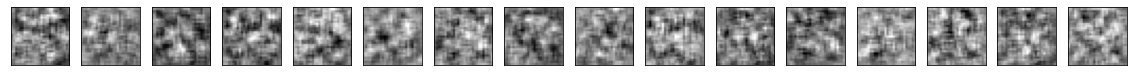

epoch 1 / 50


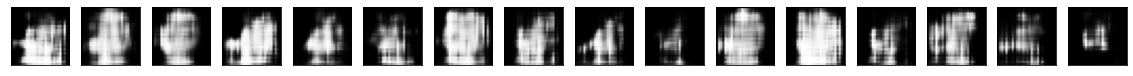

epoch 2 / 50


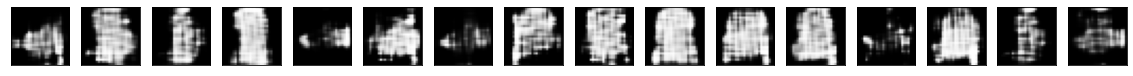

epoch 3 / 50


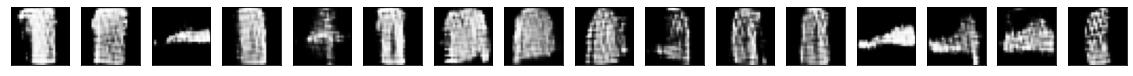

epoch 4 / 50


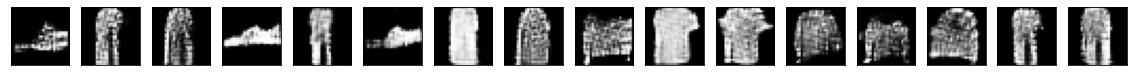

epoch 5 / 50


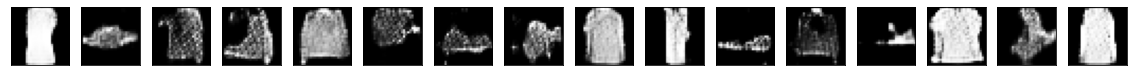

epoch 6 / 50


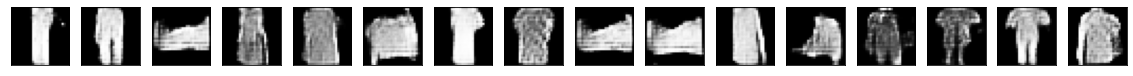

epoch 7 / 50


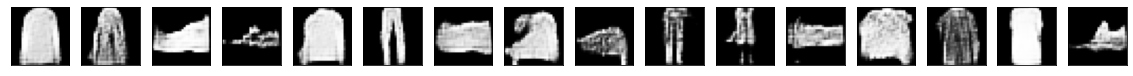

epoch 8 / 50


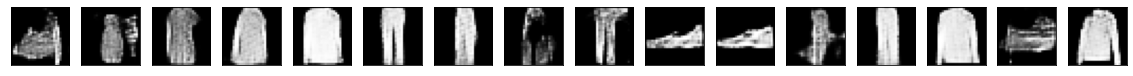

epoch 9 / 50


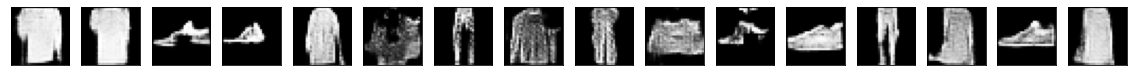

epoch 10 / 50


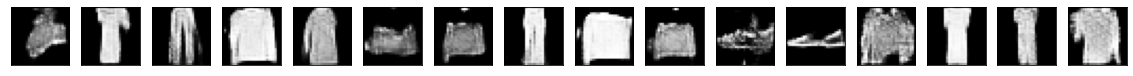

epoch 11 / 50


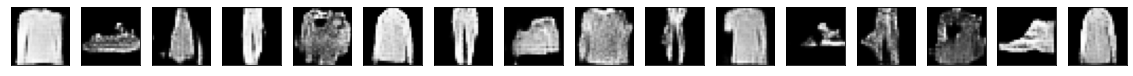

epoch 12 / 50


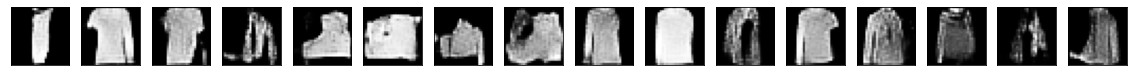

epoch 13 / 50


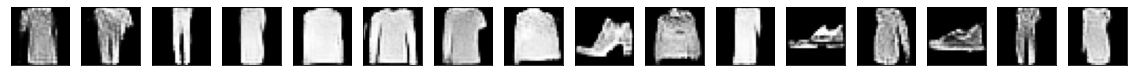

epoch 14 / 50


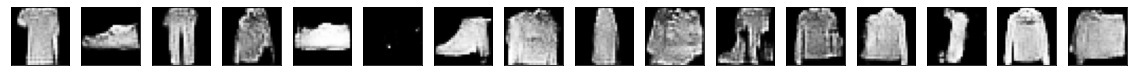

epoch 15 / 50


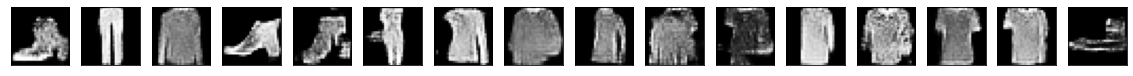

epoch 16 / 50


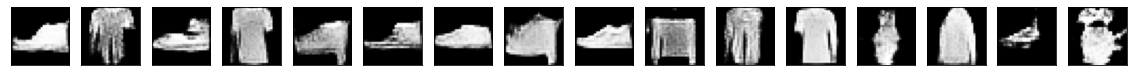

epoch 17 / 50


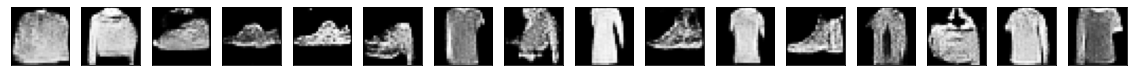

epoch 18 / 50


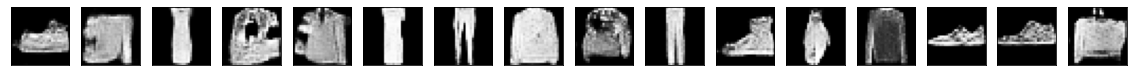

epoch 19 / 50


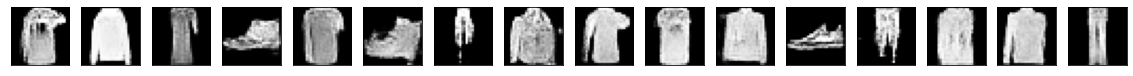

epoch 20 / 50


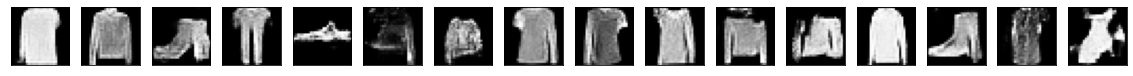

epoch 21 / 50


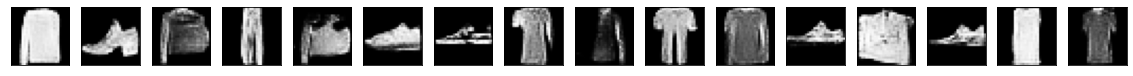

epoch 22 / 50


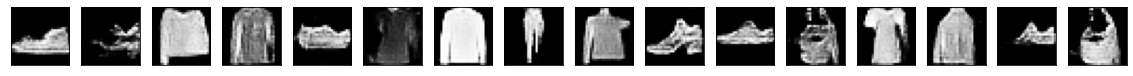

epoch 23 / 50


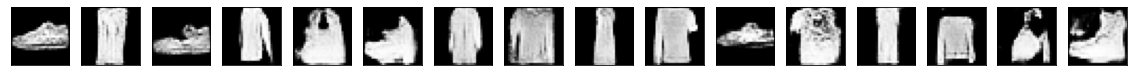

epoch 24 / 50


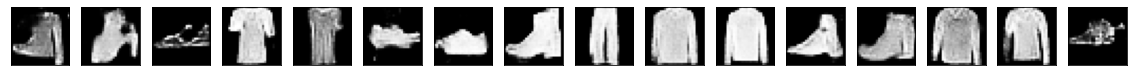

epoch 25 / 50


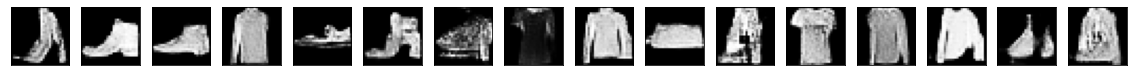

epoch 26 / 50


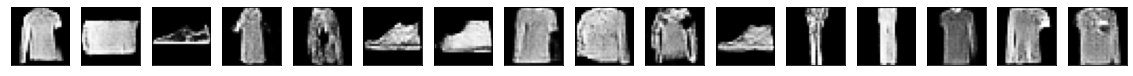

epoch 27 / 50


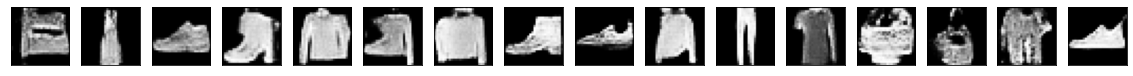

epoch 28 / 50


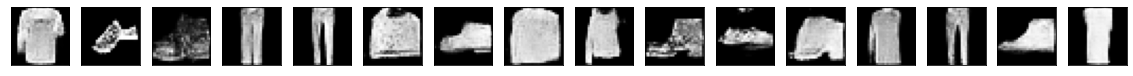

epoch 29 / 50


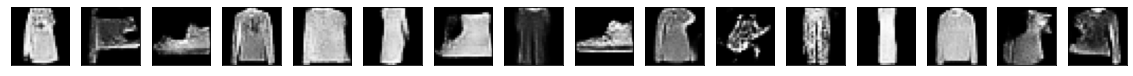

epoch 30 / 50


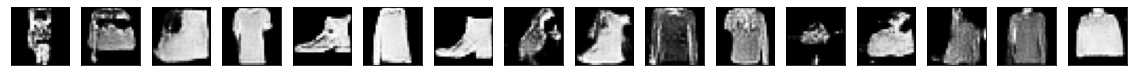

epoch 31 / 50


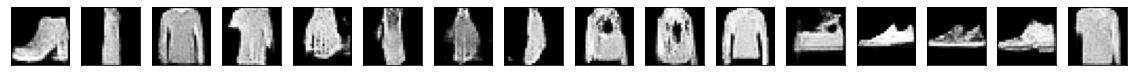

epoch 32 / 50


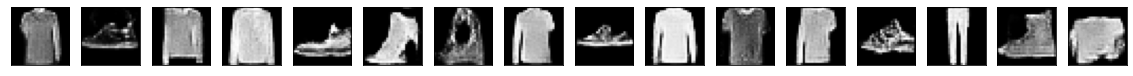

epoch 33 / 50


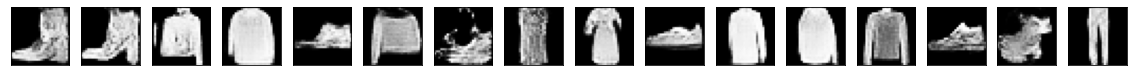

epoch 34 / 50


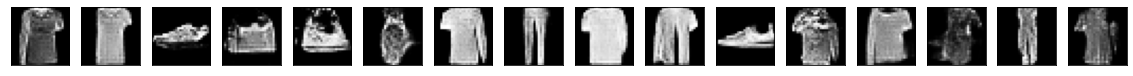

epoch 35 / 50


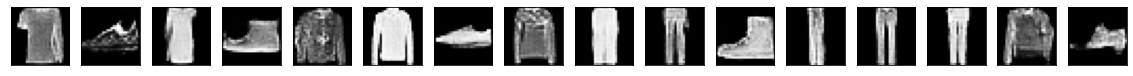

epoch 36 / 50


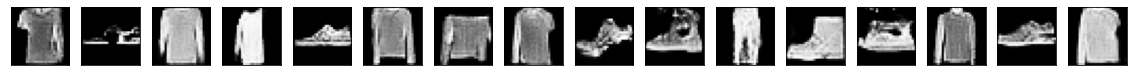

epoch 37 / 50


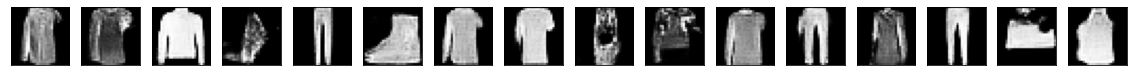

epoch 38 / 50


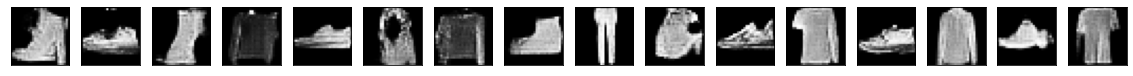

epoch 39 / 50


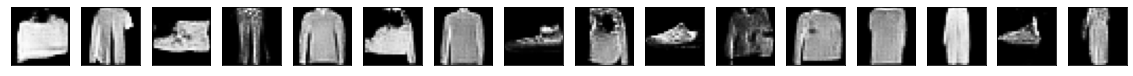

epoch 40 / 50


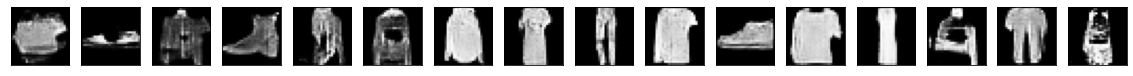

epoch 41 / 50


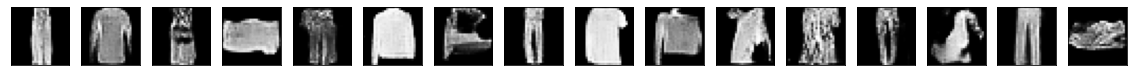

epoch 42 / 50


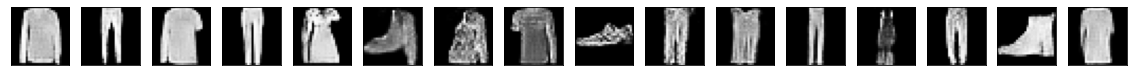

epoch 43 / 50


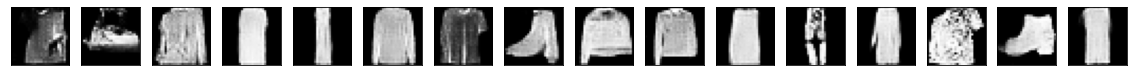

epoch 44 / 50


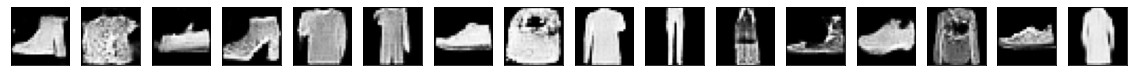

epoch 45 / 50


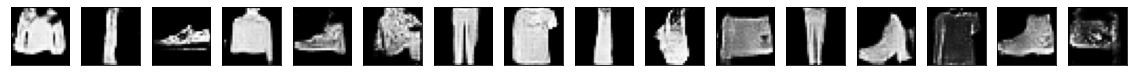

epoch 46 / 50


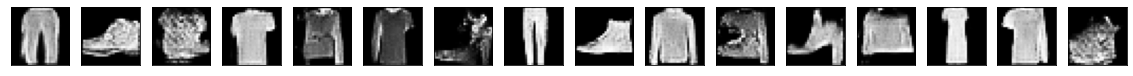

epoch 47 / 50


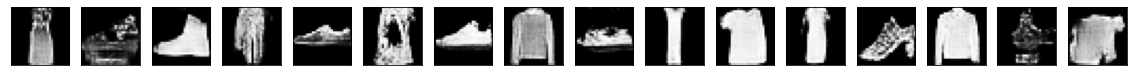

epoch 48 / 50


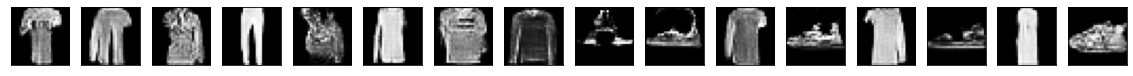

epoch 49 / 50


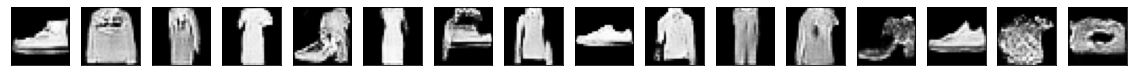

epoch 50 / 50


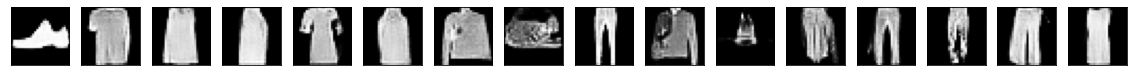

Training finished


In [7]:
def train_D(real_images):
    batch_size = real_images.shape[0]
    generated_images = G.predict(gen_noise(batch_size))
    x = np.concatenate((real_images, generated_images))
    y = np.array([1] * batch_size + [0] * batch_size)
    D.trainable = True
    D.train_on_batch(x, y)

def train_G(batch_size):
    x = gen_noise(batch_size)
    y = np.array([1]*batch_size)
    D.trainable = False
    GD.train_on_batch(x, y)

def test_and_show():
    generated = G.predict(gen_noise(16))
    plt.figure(figsize=(20,2))
    for i in range(16):
        plt.subplot(1,16,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(generated[i].reshape((H,W)), cmap='gray')
    plt.show()

epochs = 50
batch_size = 256

print('epoch', 0, '/', epochs)

test_and_show()

for epoch in range(epochs):
    for i in range(0, train_x.shape[0], batch_size):
        train_D(train_x[i:i+batch_size])
        train_G(batch_size)
    print('epoch', epoch+1, '/', epochs)
    test_and_show()
    
print("Training finished")